# DSCI 100 Final Report
# Predicting Newsletter Subscription Among Minecraft Server Players

**Names:** Terrance Wang, Julia Asakura, Luqing Wang

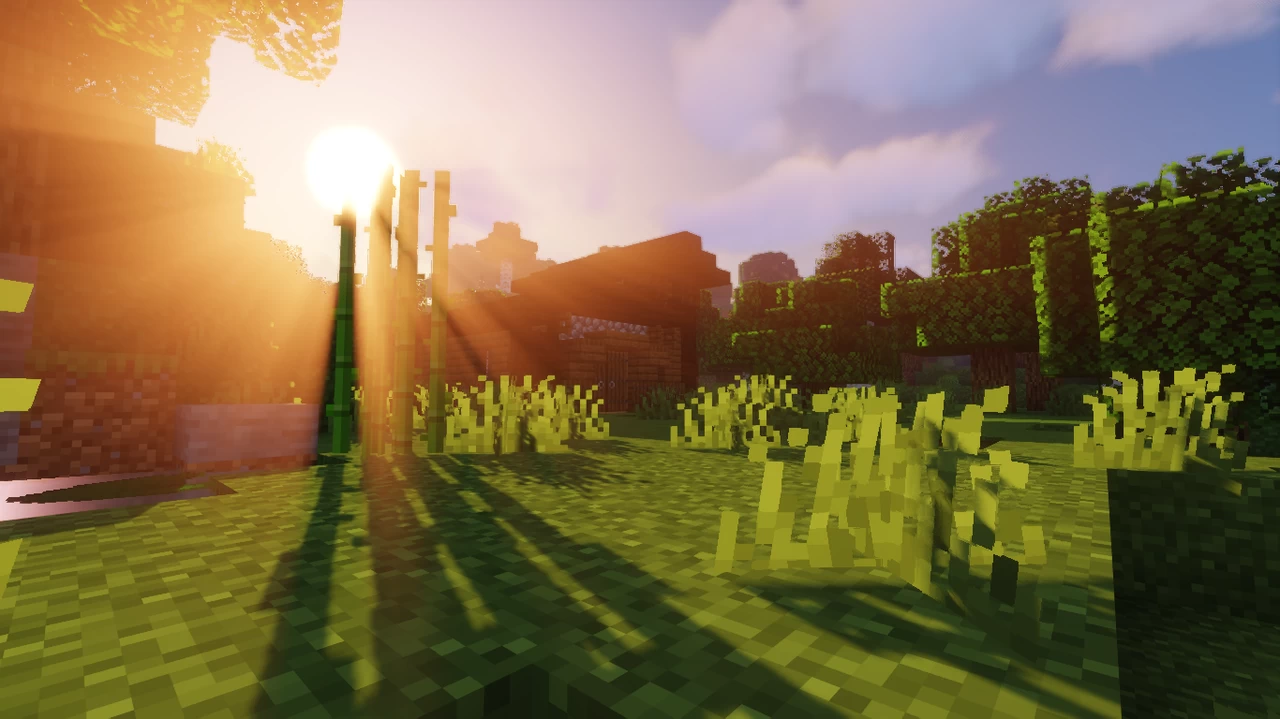

## Introduction
Understanding how players engage with online games can help researchers manage server resources and improve study participation. In this project, we worked with data from a Minecraft research server created by a UBC Computer Science group. The server records basic information about each player as well as details about every play session. One challenge the research team faces is predicting which players are likely to stay engaged with the project. In particular, they want to know which types of players are most likely to subscribe to a game-related newsletter, since subscriptions indicate interest and help with communication and recruitment.

The broad question guiding our project is: What player characteristics and behaviours are associated with whether someone subscribes to the Minecraft research newsletter? From this, we formed the more specific predictive question: ***Can a player’s age, experience level, and total hours played predict whether they subscribe to the newsletter?*** These variables are available in the data and may reflect how invested or committed a player is in the study.

Our analysis uses two datasets: players.csv, which contains one row per player with demographic information and gameplay summaries, and sessions.csv, which contains detailed records of individual play sessions. The players dataset includes variables such as age (numeric), experience level (categorical), total playtime in hours (numeric), and subscription status (logical). The sessions dataset records start and end times of each session along with the player identifier. Together, these datasets allow us to explore patterns in player behaviour and build a predictive model for newsletter subscription.

## Methods & Results

**1. Data loading and initial cleaning**

We first loaded the dataset into R and did some light cleaning to prepare them for analysis. Since our predictors (Age, experience, played_hours) and response (subscribe) all live in players.csv, we focused our modelling on this table. The sessions.csv dataset was mainly used earlier to understand how playtime is recorded, but for this project we treat played_hours as a summary of each player’s total playtime.

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("https://raw.githubusercontent.com/terrancewxngg/dsci100-project-planning/refs/heads/main/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
players_clean <- players |>
  mutate(
    experience = as_factor(experience),
    gender = as_factor(gender),
    subscribe = as_factor(subscribe)
  ) |>
  filter(
    !is.na(Age),
    !is.na(played_hours),
    !is.na(subscribe),
    !is.na(experience)
  )

This keeps only players with complete information on the variables we need for modelling.

**2. Exploratory summary and visualization**

We first summarized the quantitative predictors to understand their scale and variability.

In [4]:
players_clean |>
  summarize(
    mean_age = round(mean(Age), 2),
    sd_age   = round(sd(Age), 2),
    mean_hours = round(mean(played_hours), 2),
    sd_hours   = round(sd(played_hours), 2)
  )

mean_age,sd_age,mean_hours,sd_hours
<dbl>,<dbl>,<dbl>,<dbl>
21.14,7.39,5.9,28.5


We then created a few visualizations relevant to our question.

**Figure 1: Distribution of player ages**

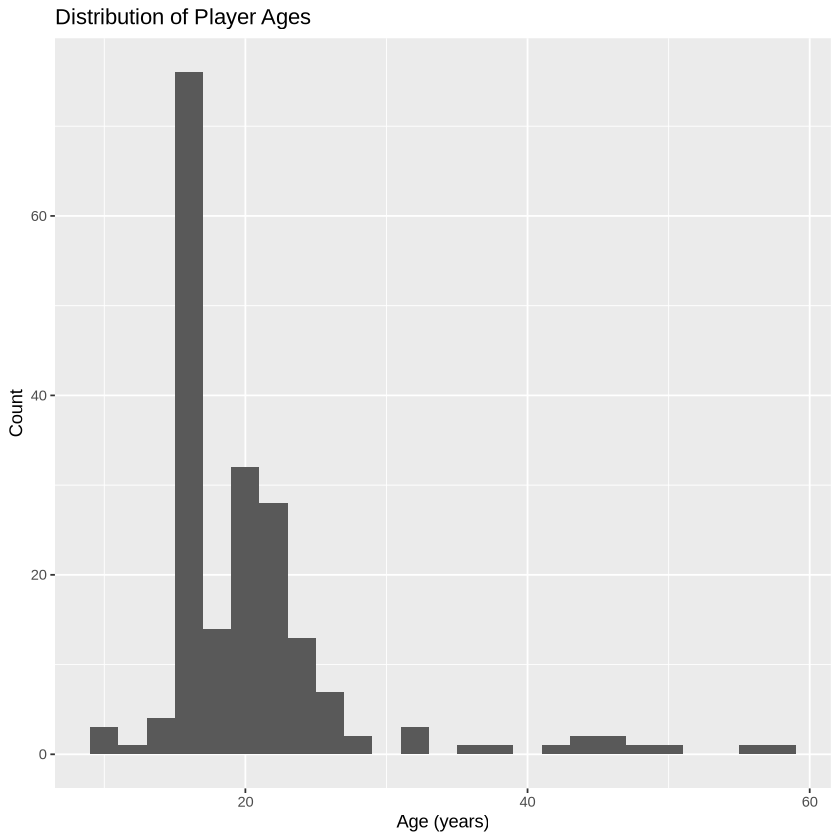

In [5]:
players_clean |>
  ggplot(aes(x = Age)) +
  geom_histogram(binwidth = 2) +
  labs(
    title = "Distribution of Player Ages",
    x = "Age (years)",
    y = "Count"
  )


*Figure 1: Most players are teenagers or young adults, with a smaller number of older players and a right-skewed age distribution.*

**Figure 2: Total hours played by subscription status**

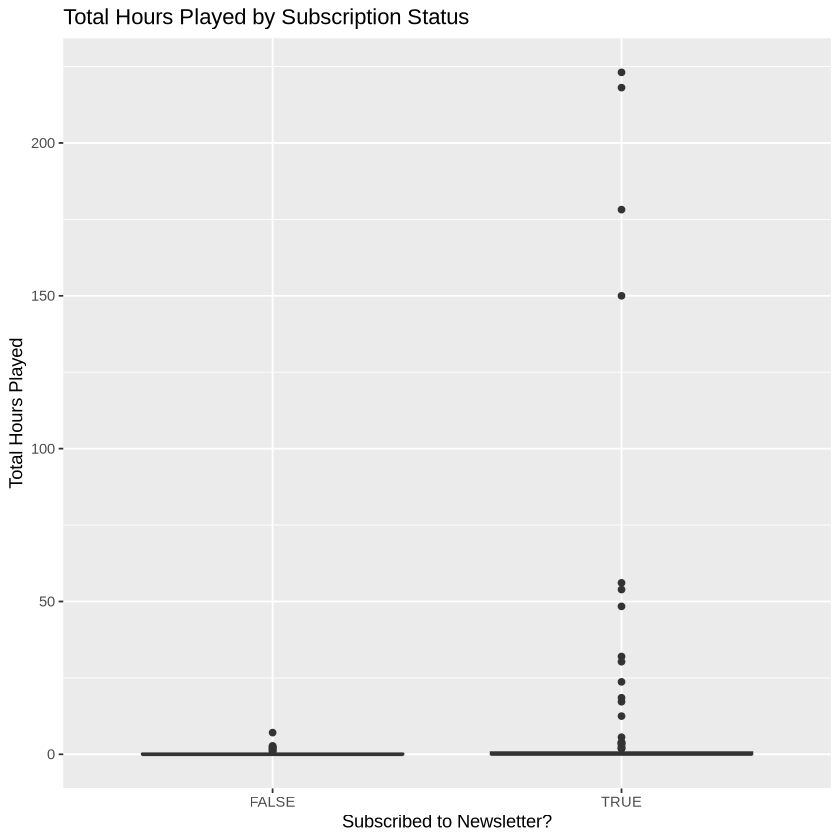

In [6]:
players_clean |>
  ggplot(aes(x = subscribe, y = played_hours)) +
  geom_boxplot() +
  labs(
    title = "Total Hours Played by Subscription Status",
    x = "Subscribed to Newsletter?",
    y = "Total Hours Played"
  )

*Figure 2: Most players have low playtime, but the highest total hours are mostly among subscribed players, suggesting that heavier players may be more likely to subscribe.*

**Figure 3: Experience level and subscription**

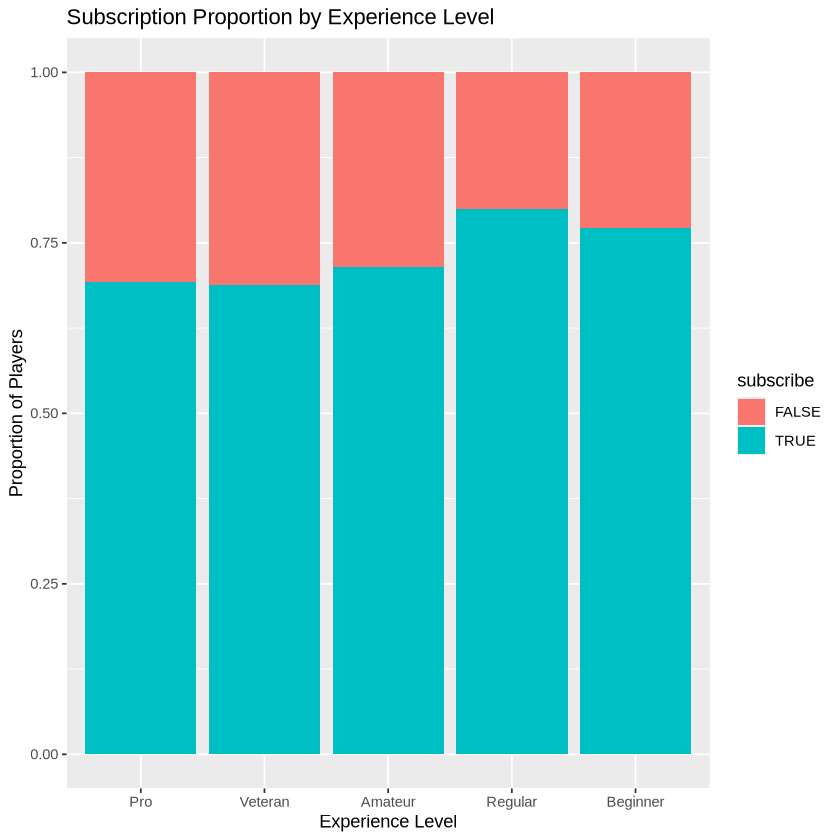

In [7]:
players_clean |>
  ggplot(aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(
    title = "Subscription Proportion by Experience Level",
    x = "Experience Level",
    y = "Proportion of Players"
  )

*Figure 3: Subscription rates are fairly high across all experience levels, with only small differences between groups, suggesting that experience alone may not strongly predict subscription.*

These plots suggested that total hours played might be more strongly related to subscription than age or experience by themselves, which motivated including all three as predictors in our model.

**3. Modelling approach: KNN classification**

To answer our question, we used a K-Nearest Neighbors (KNN) classification model with subscribe as the response and age, experience, and played_hours as predictors.

We split the data into training and testing sets using an 80/20 split, stratified by subscription status to keep the class proportions similar in both sets.

In [8]:
set.seed(123)

data_split <- initial_split(
  players_clean,
  prop = 0.8,
  strata = subscribe
)

train_data <- training(data_split)
test_data  <- testing(data_split)

We then defined a preprocessing recipe and a tunable KNN model. Numeric predictors are scaled, and the categorical predictor is kept as a factor.

In [9]:
knn_recipe <- recipe(subscribe ~ Age + experience + played_hours, data = train_data) |>
  step_normalize(all_numeric_predictors())

knn_spec <- nearest_neighbor(
  neighbors = tune()
) |>
  set_engine("kknn") |>
  set_mode("classification")

We combined the recipe and model into a workflow:

In [10]:
knn_workflow <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec)

**4. Model tuning and cross-validation**

To choose a good value of k, we used 10-fold cross-validation on the training set and tuned over a range of possible neighbor values.

In [11]:
set.seed(123)

knn_folds <- vfold_cv(train_data, v = 10, strata = subscribe)

knn_grid <- tibble(neighbors = seq(1, 25, by = 2))

knn_tuned <- knn_workflow |>
  tune_grid(
    resamples = knn_folds,
    grid = knn_grid,
    metrics = metric_set(accuracy)
  )

knn_metrics <- knn_tuned |>
  collect_metrics()
knn_metrics

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5567892,10,0.02359095,Preprocessor1_Model01
3,accuracy,binary,0.5501225,10,0.02317242,Preprocessor1_Model02
5,accuracy,binary,0.6006373,10,0.02858663,Preprocessor1_Model03
7,accuracy,binary,0.6331373,10,0.03123636,Preprocessor1_Model04
9,accuracy,binary,0.7127206,10,0.02604660,Preprocessor1_Model05
11,accuracy,binary,0.7193873,10,0.02138016,Preprocessor1_Model06
13,accuracy,binary,0.7268382,10,0.01930558,Preprocessor1_Model07
15,accuracy,binary,0.7468382,10,0.01754268,Preprocessor1_Model08
17,accuracy,binary,0.7468382,10,0.01754268,Preprocessor1_Model09


**Figure 4: Accuracy vs number of neighbors**

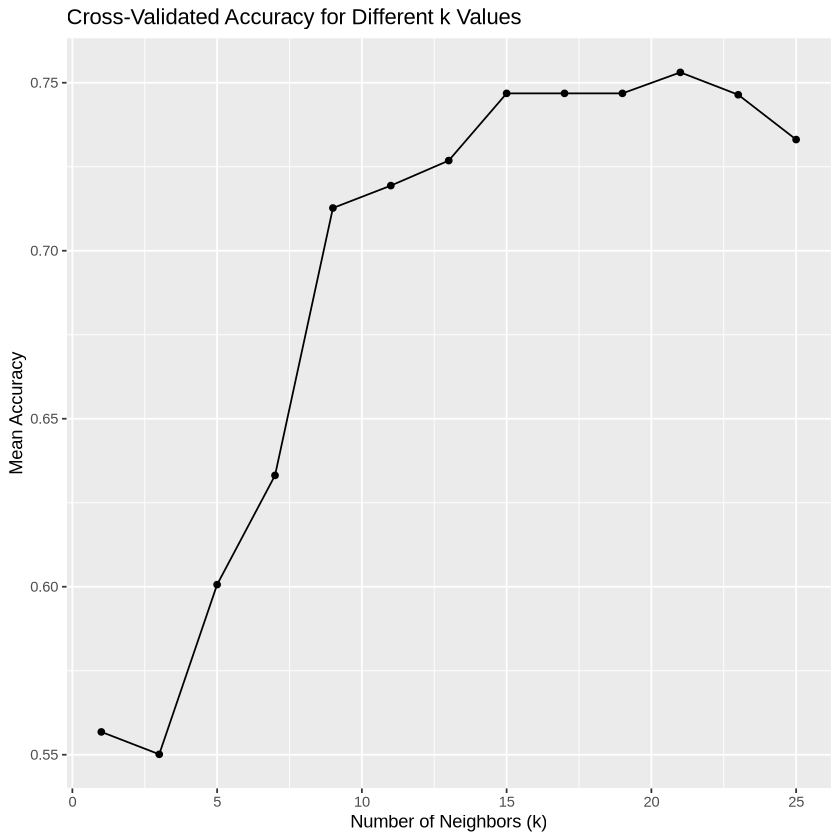

In [12]:
knn_metrics |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(
    title = "Cross-Validated Accuracy for Different k Values",
    x = "Number of Neighbors (k)",
    y = "Mean Accuracy"
  )

*Figure 4: Cross-validated accuracy for different values of k. The best-performing region indicates the k values that balance underfitting and overfitting.*

From this plot and the metrics, we selected the value of k with the highest mean accuracy (if multiple are similar, we can choose the simplest/smaller k).

In [13]:
best_k <- knn_tuned |>
  select_best(metric = "accuracy")

best_k

neighbors,.config
<dbl>,<chr>
21,Preprocessor1_Model11


Based on cross-validation accuracy, the model with k = 21 neighbors performed the best, so this value was selected for the final KNN classifier.

We then finalized the model with this chosen k:

In [14]:
final_knn_workflow <- knn_workflow |>
  finalize_workflow(best_k)

final_knn_fit <- final_knn_workflow |>
  fit(data = train_data)

**5. Test-set evaluation**

Finally, we evaluated the model on the held-out test set to see how well it generalizes to new players.

In [15]:
knn_test_preds <- predict(final_knn_fit, new_data = test_data) |>
  bind_cols(test_data |>
              select(subscribe))

knn_results <- knn_test_preds |>
  metrics(truth = subscribe, estimate = .pred_class)

knn_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.70000000
kap,binary,-0.04803493


The final KNN model achieved a test accuracy of 70%, meaning it correctly predicted the subscription status for 7 out of 10 players in the test set.

We also examined the confusion matrix to understand which classes the model gets right and wrong.

In [16]:
knn_conf_mat <- knn_test_preds |>
  conf_mat(truth = subscribe, estimate = .pred_class)

knn_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE     11   28

This evaluation helps us see whether the model is more likely to misclassify subscribers or non-subscribers, which is important for interpreting the practical usefulness of the model.

## Discussion (and a few things we didn’t expect to learn from this dataset...!) ##


Our project asked whether a player’s age, experience level, and total hours played could be used to predict whether they subscribed to the Minecraft research newsletter. From the exploratory analysis, we noticed that players with very high total playtime were more likely to subscribe, while age and experience showed weaker patterns. After tuning the model, the final KNN classifier with k = 21 neighbors achieved a test accuracy of about 70%, meaning it was able to correctly predict subscription status for most players in the test set.

These results were not completely what we expected. Based on the EDA, it seemed reasonable to think that older or more experienced players would be more likely to subscribe, but the model did not find strong predictive value in those variables. Total hours played had the strongest relationship with subscription, especially for players with extremely high playtime, but this was not enough to produce a highly reliable classifier. This suggests that the predictors we chose are related to subscription behaviour, but not strongly enough to make consistently accurate individual-level predictions.

Even with these limitations, the findings still have practical value. The fairly high subscription rate across different experience levels suggests that many kinds of players are willing to subscribe, not just those who consider themselves very advanced. This means recruitment efforts do not necessarily have to target specific demographic or experience groups. At the same time, the trend that high-playtime players are more likely to subscribe indicates that players who are already active on the server may be especially responsive to newsletter prompts or follow-up communication.

This analysis also highlights limitations and possible future directions. Our model only used three predictors from players.csv, and we did not incorporate behavioural information from sessions.csv, such as number of sessions, average session length, or typical play times. The dataset is relatively small, and the playtime variable is skewed with some large outliers, which can affect the performance of KNN. Future work could compare KNN with other models such as logistic regression, engineer additional features from session-level data, and evaluate models against simple baselines. It may also be valuable to explore other outcomes, such as which players return most often or contribute the most total playtime, rather than focusing only on newsletter subscription.





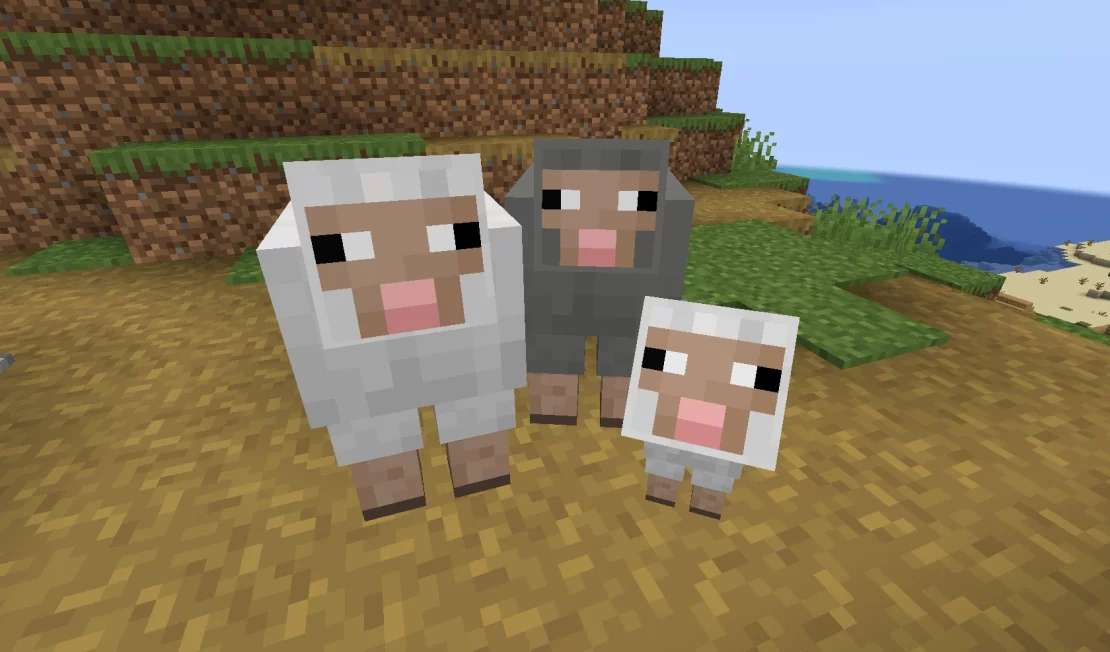